In [133]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

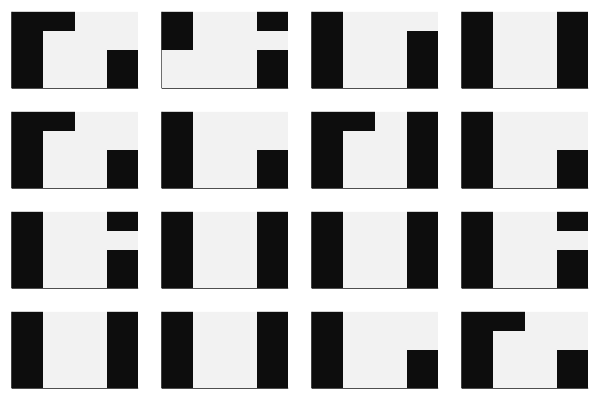

In [134]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 8 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [135]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
#d = Chain(Conv(N, 10, relu), Conv(10, 1, sigmoid)) #Change?
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

# function create_cnn()
#     return Chain(
#         Conv((3, 3), 1=>16, relu),
#         MaxPool((2, 2)),
#         Conv((3, 3), 16=>32, relu),
#         MaxPool((2, 2)),
#         flatten,
#         Dense(512, 128, relu),
#         Dense(128, 10),
#     )
# end

# function create_cnn()
#     return Chain(
#         Conv((3, 3), 1=>16, relu),
#         MaxPool((2, 2)),
#         Conv((3, 3), 16=>32, relu),
#         MaxPool((2, 2)),
#         flatten,
#         Dense(512, 128, relu),
#         Dense(128, 10),
#     )
# end

#d = create_cnn() 

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π);

Number of parameters in discriminator: 181
Number of parameters in generator: 230


nqubits: 16
chain
├─ rot(nqubits: 16
kron
├─ 1=>X
└─ 2=>X, 2.1695530440669346)
├─ rot(nqubits: 16
kron
├─ 2=>X
└─ 3=>X, 4.784963470701344)
├─ rot(nqubits: 16
kron
├─ 3=>X
└─ 4=>X, 2.771419402550331)
├─ rot(nqubits: 16
kron
├─ 4=>X
└─ 5=>X, 5.516480604689814)
├─ rot(nqubits: 16
kron
├─ 5=>X
└─ 6=>X, 5.785252434913715)
├─ rot(nqubits: 16
kron
├─ 6=>X
└─ 7=>X, 1.6176022283309697)
├─ rot(nqubits: 16
kron
├─ 7=>X
└─ 8=>X, 1.1012483961416282)
├─ rot(nqubits: 16
kron
├─ 8=>X
└─ 9=>X, 0.06457495252902934)
├─ rot(nqubits: 16
kron
├─ 9=>X
└─ 10=>X, 0.15983186526061943)
├─ rot(nqubits: 16
kron
├─ 10=>X
└─ 11=>X, 5.674890345644102)
├─ rot(nqubits: 16
kron
├─ 11=>X
└─ 12=>X, 2.8839357906337004)
├─ rot(nqubits: 16
kron
├─ 12=>X
└─ 13=>X, 3.1200927110279477)
├─ rot(nqubits: 16
kron
├─ 13=>X
└─ 14=>X, 0.5700892479205064)
├─ rot(nqubits: 16
kron
├─ 14=>X
└─ 15=>X, 2.441500583638378)
├─ rot(nqubits: 16
kron
├─ 15=>X
└─ 16=>X, 1.2391312385031537)
├─ rot(nqubits: 16
kron
├─ 1=>X
└─ 2=>Y, 5.600977224905793

μ: 8.875
σ: 1.02469507659596
0.5546875
Bool[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

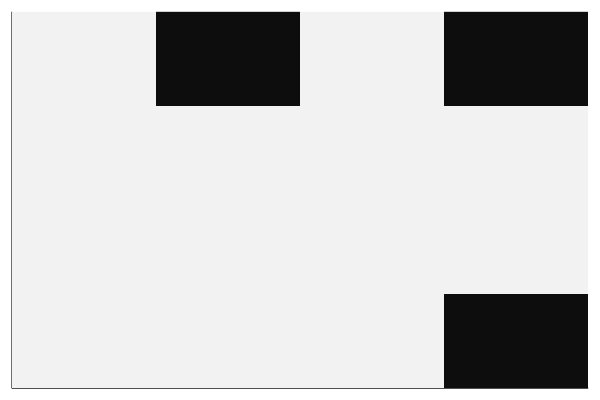

In [136]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
#dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = mu/N #if ratio = 0 then pprior() is all 0s
println(ratio)
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [137]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.5936298f0

In [138]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

parametershift_grad (generic function with 2 methods)

In [139]:
g_lr = 1e-1 #Usually is like 10^{-3} to 10^{-4}
d_lr = 1e-3

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

function dtest_real(nbatch = train)
    l = []
    for i in 1:nbatch
        d_real = data_train[i] |> vec |> d |> first
        push!(l, d_real)
    end
    mean(l)
end

function dtest_fake(nbatch = train)
    l = []
    mean(run_d_fake(run_g(nbatch = nbatch)))
end

@time dtest_real()
@time dtest_fake()

  0.010491 seconds (2.94 k allocations: 199.778 KiB, 97.07% compilation time)


  0.096933 seconds (205.27 k allocations: 12.050 MiB, 96.51% compilation time)


0.54422504f0

In [140]:

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []
#Keep track of avg discriminator output on real vs. fake data and make sure none of them gets too small or too large
g_epochs = 5 #Dynamically change this during training? Keep g_epochs constant and dynamically vary d_epochs
d_epochs = 2
epochs = 10
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    for j in 1:d_epochs
        if (j > 1) & (dtest_real() > 0.6)
            break
        end
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    push!(dreal_vals, dtest_real())
    push!(dfake_vals, dtest_fake())
    println("iteration $i done in: ", time() - t)
end

#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
    push!(dreal_vals, dtest_real())
    push!(dfake_vals, dtest_fake())
end

iteration 1 done in: 38.119094133377075
iteration 2 done in: 

37.854873180389404


iteration 3 done in: 37.81609296798706
iteration 4 done in: 

37.45411705970764


iteration 5 done in: 37.8231098651886
iteration 6 done in: 

37.302666902542114


iteration 7 done in: 37.46544599533081
iteration 8 done in: 

37.64992809295654


iteration 9 done in: 37.4769229888916
iteration 10 done in: 

37.74488115310669


Generator loss
Any[0.5831796f0, 0.5630863f0, 0.6176252f0, 0.6186935f0, 0.572107f0, 0.6012852f0, 0.65258265f0, 0.64264673f0, 0.6449865f0, 0.54349035f0, 0.72425324f0, 0.68797004f0, 0.6670551f0, 0.683134f0, 0.68981165f0, 0.7340207f0, 0.79075974f0, 0.7472232f0, 0.6992729f0, 0.7725057f0, 0.836361f0, 0.81214786f0, 0.7833326f0, 0.809134f0, 0.8140371f0, 0.8893093f0, 0.79899377f0, 0.81403345f0, 0.84393126f0, 0.8309392f0, 0.92742246f0, 0.8674755f0, 0.9097833f0, 0.90718704f0, 0.93042266f0, 0.9876398f0, 0.9158191f0, 0.92865944f0, 0.9183916f0, 0.9986845f0, 0.96893364f0, 0.94096875f0, 1.0002353f0, 0.9811866f0, 1.0751816f0, 1.1246402f0, 1.0379438f0, 1.0024729f0, 1.0432533f0, 0.998732f0, 1.1555871f0, 1.0834298f0, 1.1181223f0, 1.1622772f0, 1.2277802f0]


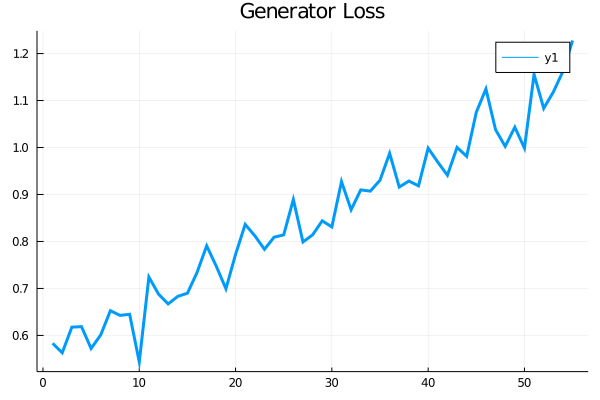

In [141]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.3115592f0, 1.2298305f0, 1.189933f0, 1.0831599f0, 1.0050071f0, 0.94511485f0, 1.0182953f0, 0.87953204f0, 0.85603917f0, 0.92782044f0]


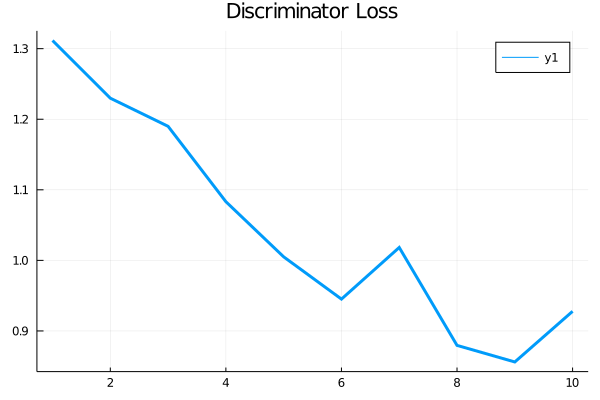

In [142]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients
Any[-0.0007413914670114932, -0.0011391468670057213, 0.0017374540152757065, 0.0015958668097205784, 0.001234095899955086, -0.00053126177062159, 0.002539701565452244, -0.00023832528487495753, -0.0012119196031404578, -0.0012246591889339944, 0.002478068548700084, 0.0003419505513232687, 0.002391043175821719, 0.0012490253085675447, 0.000663403842760169, -9.23770925273066e-5, -0.0012283789074939231, 0.00039722997209300166, 0.0012241166570912236, 0.0010469688021618386, 0.0018912219482919443, -0.0008657268855882728, 0.0009021266647007154, 8.634562077729598e-5, 0.001239366635032322, -0.0003107042416282322, 0.0011208254358042841, 0.0011010953913564267, 0.0008501690366993779, 0.0003734451273213262, -0.0018525483815566353, 0.0008642080037490181, 0.0003992470710173897, -0.0012760302294855532, -0.0006437324959298839, 0.0003604452247204988, -0.002087095768555351, -7.25660635077435e-6, 0.0007040365882541822, 4.813437876494035e-5, -0.002548961017442786, 0.0003970436427904212, -0.0016340128

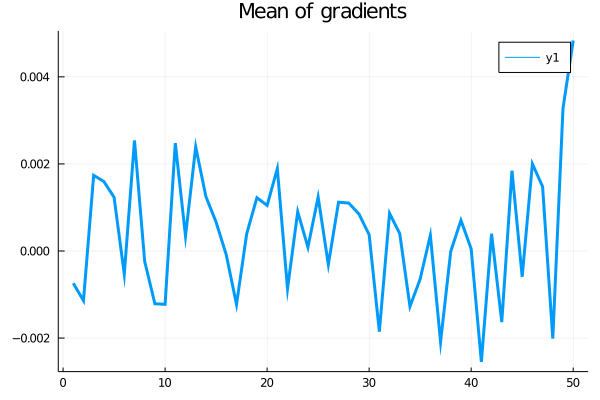

In [143]:
println("Mean gradients")

println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [144]:
#Testing the Discriminator

d_real = dtest_real()
println("real data: $d_real") #Should print a number close to 1

d_fake = dtest_fake()
println("fake data: $d_fake") #Should print a number close to 0

real data: 0.6848869
fake data: 0.3381669


In [145]:
for x in dreal_vals
    println(x)
end

0.6414161
0.63618034
0.6319839
0.63156384
0.6403078
0.6478775
0.6538821
0.663471
0.6762904
0.6848869
0.6848869
0.6848869
0.6848869
0.6848869
0.6848869


In [146]:
for x in dfake_vals
    println(x)
end
println(length(dfake_vals))

0.5598211
0.5366545
0.45700765
0.49656776
0.50539535
0.41902277
0.476948
0.41274276
0.38411596
0.3189488
0.3144197
0.36905512
0.37522826
0.3289005
0.39216277
15


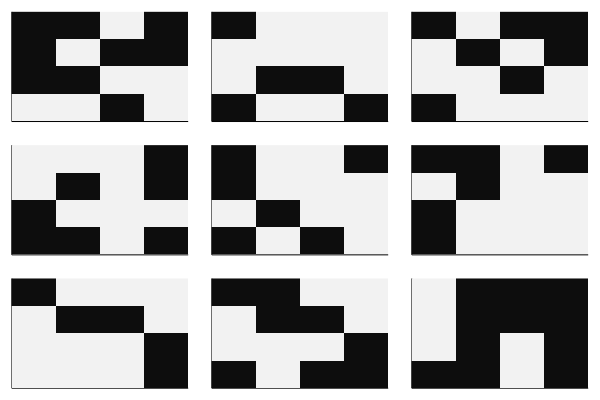

In [147]:
#Testing the Generator

nsamples = 9
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)